<a href="https://colab.research.google.com/github/BharathMenon/API_testing_Cyber-o-day_hackathon/blob/main/Corn_Maize_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle


In [1]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json


In [9]:
#! kaggle competitions download <name-of-competition> - command to download competition dataset
! kaggle datasets download smaranjitghose/corn-or-maize-leaf-disease-dataset # command to download normal dataset



 94% 151M/161M [00:01<00:00, 153MB/s]
100% 161M/161M [00:01<00:00, 130MB/s]


In [15]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import shutil


In [11]:
!unzip corn-or-maize-leaf-disease-dataset.zip

Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Corn_Blight (1010).JPG  
  inflating: data/Blight/Corn_Blight (1011).jpg  
  inflating: data/Blight/Corn_Blight (1012).JPG  
  inflating: data/Blight/Corn_Blight (1013).JPG  
  inflatin

In [ ]:

# shutil.rmtree('/content/PlantVillage/Potato___healthy')
# shutil.rmtree('/content/PlantVillage/Potato___Late_blight')
#shutil.rmtree('/content/PlantVillage/Potato___Late_blight')
# shutil.rmtree('/content/PlantVillage/Potato___Early_blight')
# shutil.rmtree('/content/PlantVillage/Pepper__bell___healthy')
#shutil.rmtree('/content/PlantVillage')

In [13]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [12]:
img_size = 256
b_size = 32
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"/content/data",
shuffle=True, #every time dataset is accesed all images are shuffled
 image_size = (img_size,img_size),
    batch_size=128 #size of every element in dataset
)

Found 4188 files belonging to 4 classes.


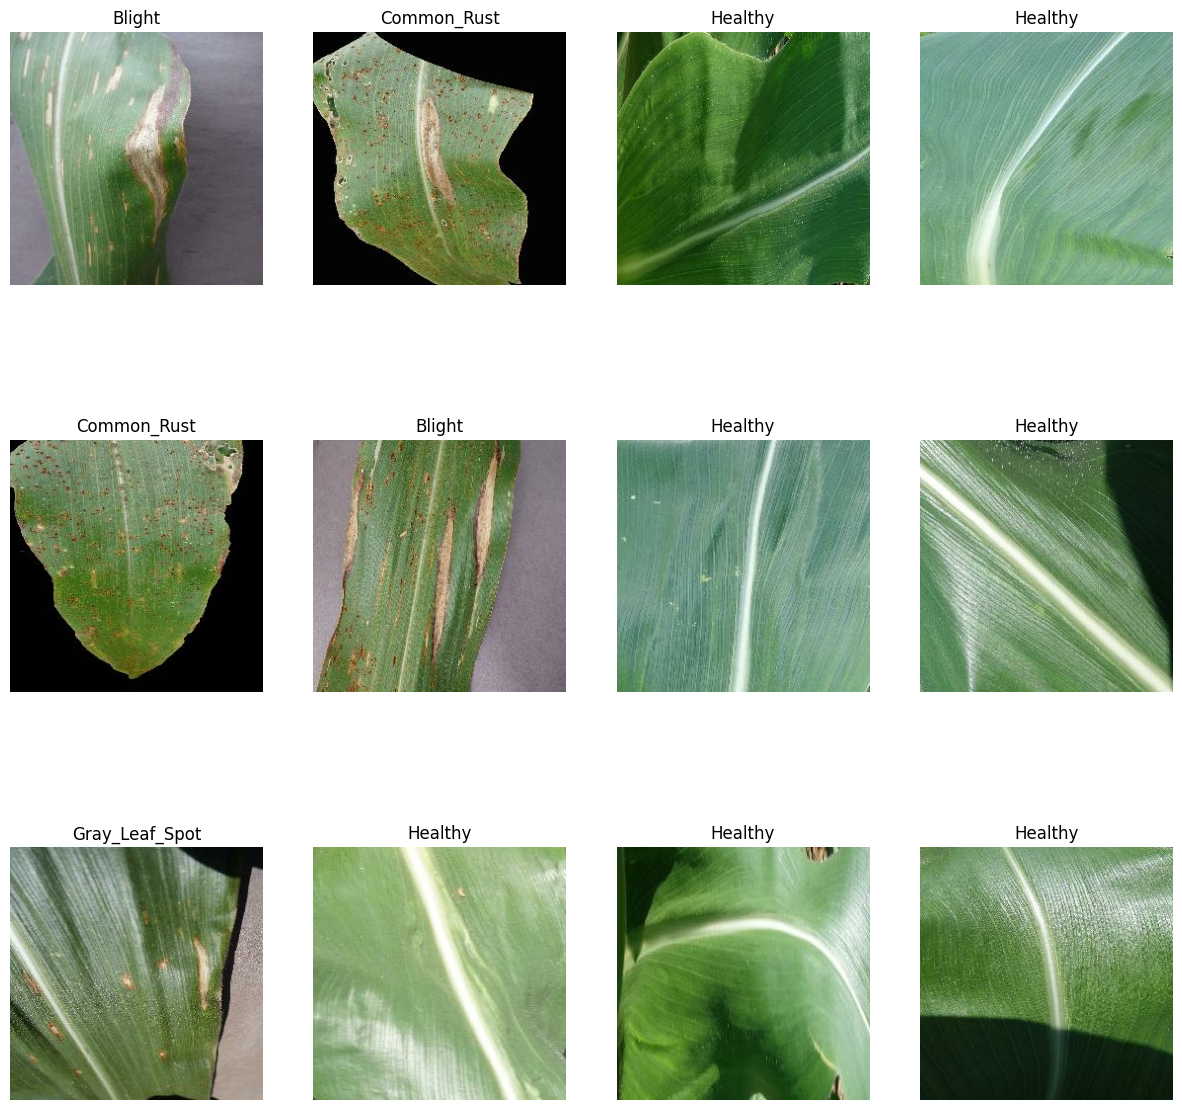

In [16]:
plt.figure(figsize=(15,15)) #Used to increase figure size
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
#         print(image_batch.shape)
#         print(label_batch.numpy().shape)

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=7)
    train_size=int(ds_size*train_split)
    test_size = int(ds_size*test_split)
    val_size = int(ds_size*val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
len(val_ds)

3

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # cache() saves all data read in one epoch so that in future epochs it won't have to read
#the data once again, hence optimising process
#prefetch() loads next batch of data while current one is running and hence optimises time.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
n_classes = 4
input_shape = (b_size,img_size,img_size,3)
model = models.Sequential([
    #layers.InputLayer(input_shape=input_shape),
    resize_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(96,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
   layers.Conv2D(128,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    #layers.Dense(80,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax') #Softmax normalises probability of classes.
])
model.build(input_shape=input_shape)

In [27]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [28]:
history =  model.fit(train_ds,epochs=50,batch_size=b_size,verbose=1,validation_data=val_ds)

Epoch 1/50
26/26 [==============================] - 26s 491ms/step - loss: 1.0144 - accuracy: 0.5610 - val_loss: 0.7782 - val_accuracy: 0.6771
Epoch 2/50
26/26 [==============================] - 12s 479ms/step - loss: 0.4409 - accuracy: 0.8257 - val_loss: 0.4291 - val_accuracy: 0.7995
Epoch 3/50
26/26 [==============================] - 12s 472ms/step - loss: 0.3983 - accuracy: 0.8416 - val_loss: 0.4371 - val_accuracy: 0.8021
Epoch 4/50
26/26 [==============================] - 12s 466ms/step - loss: 0.3745 - accuracy: 0.8441 - val_loss: 0.3263 - val_accuracy: 0.8698
Epoch 5/50
26/26 [==============================] - 12s 464ms/step - loss: 0.3473 - accuracy: 0.8507 - val_loss: 0.2937 - val_accuracy: 0.8542
Epoch 6/50
26/26 [==============================] - 12s 465ms/step - loss: 0.3175 - accuracy: 0.8558 - val_loss: 0.2867 - val_accuracy: 0.8724
Epoch 7/50
26/26 [==============================] - 12s 466ms/step - loss: 0.3125 - accuracy: 0.8705 - val_loss: 0.2949 - val_accuracy: 0.8411

In [29]:
model.evaluate(test_ds)


4/4 [==============================] - 4s 1s/step - loss: 0.1728 - accuracy: 0.9412


[0.17284245789051056, 0.9411764740943909]